In [67]:
from keras import models, layers, optimizers
from keras.models import load_model
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/Kaggle

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Kaggle


In [68]:
model = load_model('cats_and_dogs_small_2.h5')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 15, 15, 128)      

In [69]:
import numpy as np
from keras.preprocessing import image

img_path = 'cats_and_dogs_small/test/cats/cat.1700.jpg'
img = image.load_img(img_path, target_size=(150,150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
print(img_tensor.shape)

(1, 150, 150, 3)


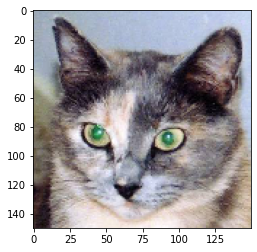

In [70]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In [71]:
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_tensor)
for activation in activations:
  print(activation.shape)

(1, 148, 148, 32)
(1, 74, 74, 32)
(1, 72, 72, 64)
(1, 36, 36, 64)
(1, 34, 34, 128)
(1, 17, 17, 128)
(1, 15, 15, 128)
(1, 7, 7, 128)


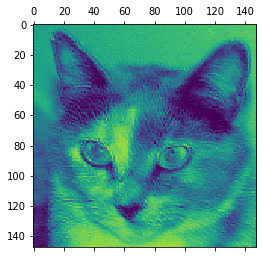

In [72]:
plt.matshow(activations[0][0,:,:,1], cmap='viridis')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


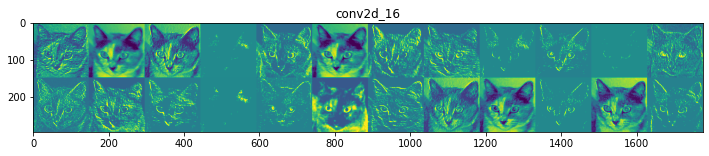

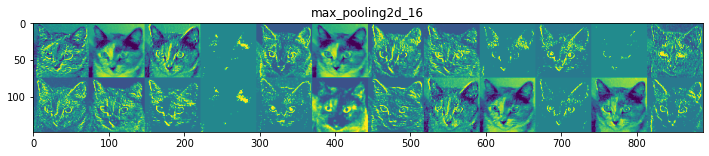

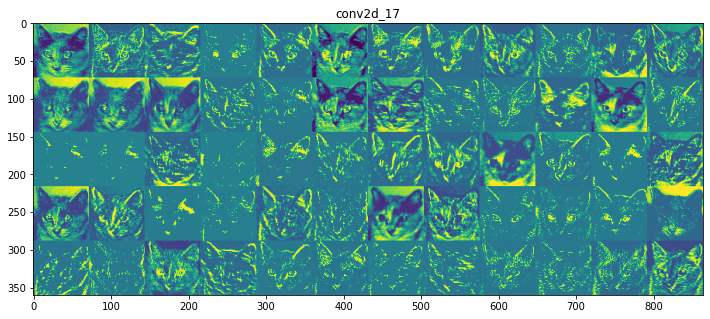

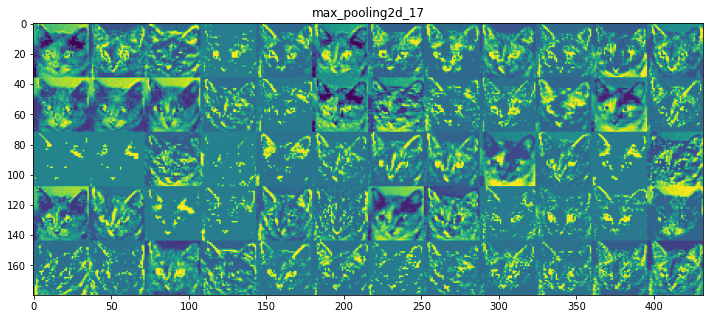

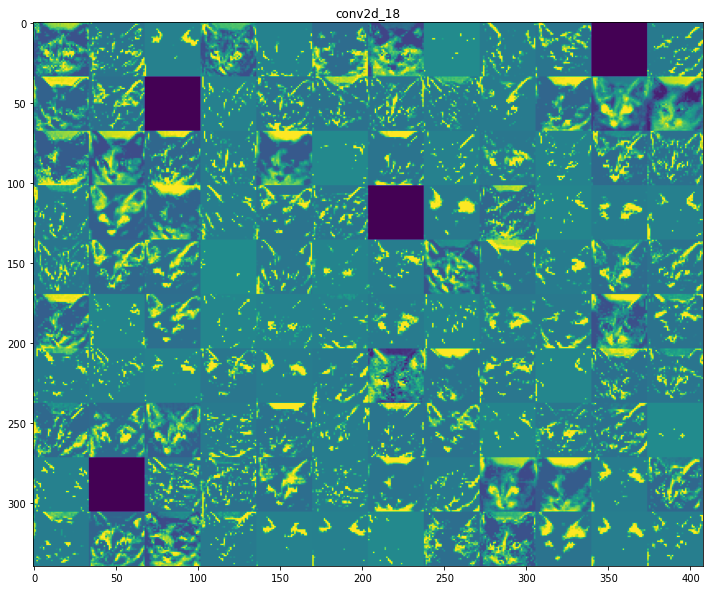

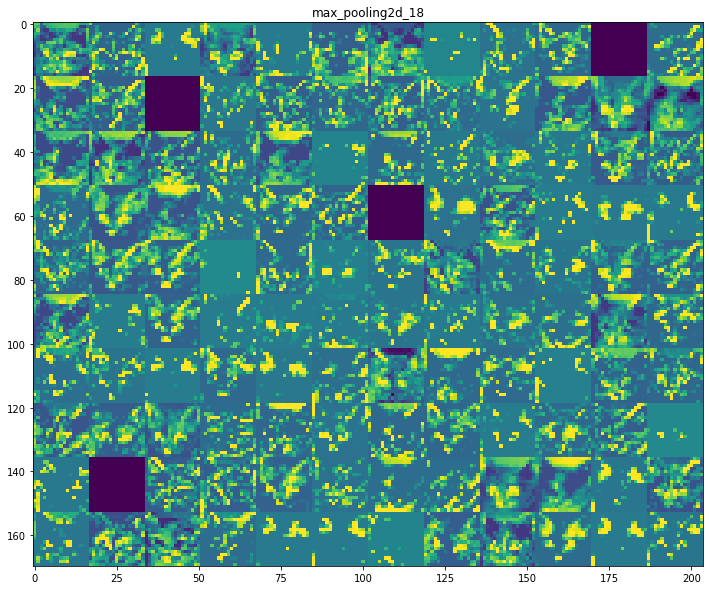

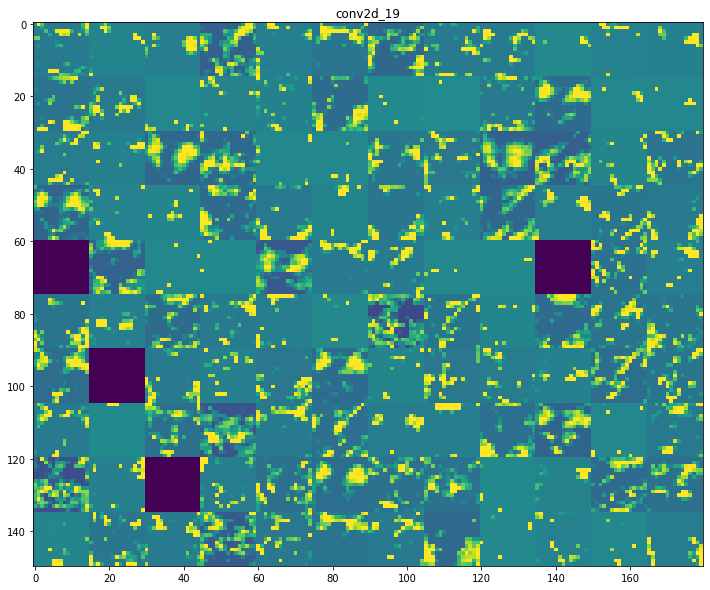

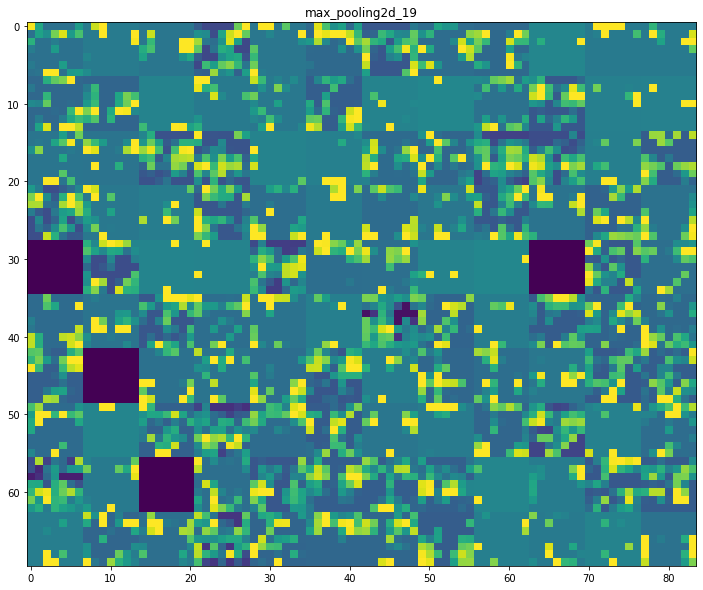

In [73]:
n_cols = 12
layer_names = []
for layer in model.layers[:8]:
  layer_names.append(layer.name)

for layer_name, layer_activation in zip(layer_names, activations):
  n_features = layer_activation.shape[-1]
  assert layer_activation.shape[1] == layer_activation.shape[2]
  size = layer_activation.shape[1]
  
  n_rows = n_features // n_cols
  display_grid = np.zeros((n_rows * size, n_cols * size))

  for row in range(n_rows):
    for col in range(n_cols):
      channel_image = layer_activation[0,:,:,row*n_cols+col]
      channel_image -= channel_image.mean()
      channel_image /= channel_image.std()
      channel_image *= 64
      channel_image += 128
      channel_image = np.clip(channel_image, 0, 255).astype('uint8')
      display_grid[row * size: (row+1) * size,
                   col * size: (col+1) * size] = channel_image
  scale = 1./size
  plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
  plt.title(layer_name)
  plt.grid(False)
  plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()

In [74]:
from keras import backend as K
from keras.applications import VGG16
import numpy as np
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

model = VGG16(weights='imagenet',
              include_top=False)

In [75]:
def process_image(x):
  x -= x.mean()
  x /= (x.std() + 1e-5)
  x *= 0.1

  x += 0.5
  x = np.clip(x, 0, 1)

  x *= 255
  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [76]:
def generate_pattern(layer_name, filter_index, size=150):
  layer_output = model.get_layer(layer_name).output
  loss = K.mean(layer_output[:,:,:,filter_index])
  grads = K.gradients(loss, model.input)[0]
  grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
  iterate = K.function([model.input], [loss, grads])
  input_img = np.random.random((1,size,size,3)) * 20 + 128
  step = 1.
  for i in range(40):
    loss_value, grads_value = iterate([input_img])
    input_img += grads_value * step
  return process_image(input_img[0])

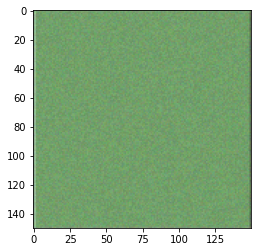

In [77]:
plt.imshow(generate_pattern('block1_conv1',2))
plt.show()

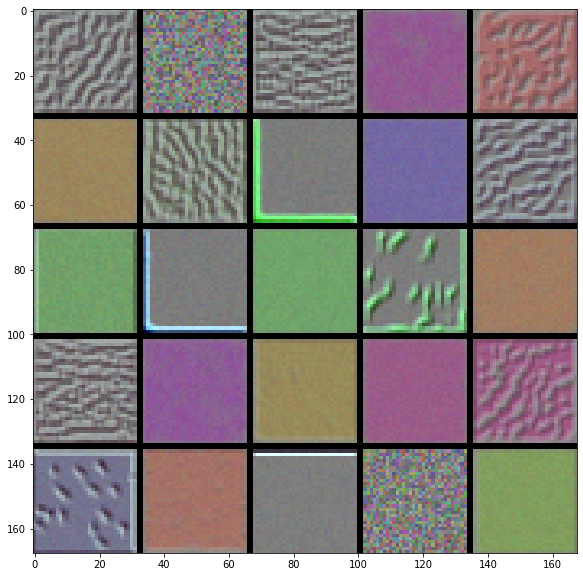

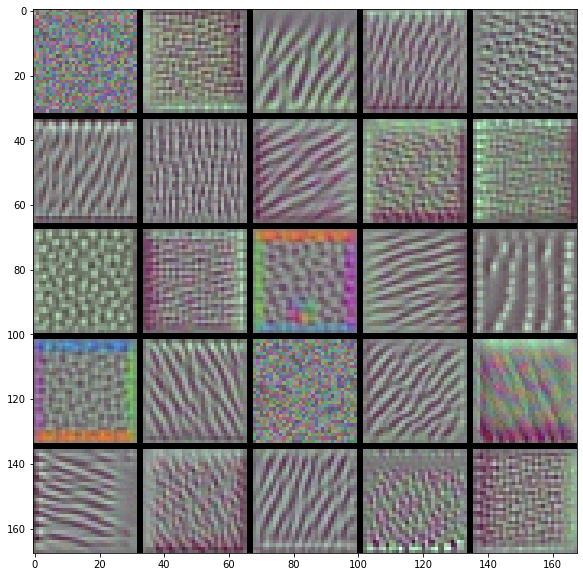

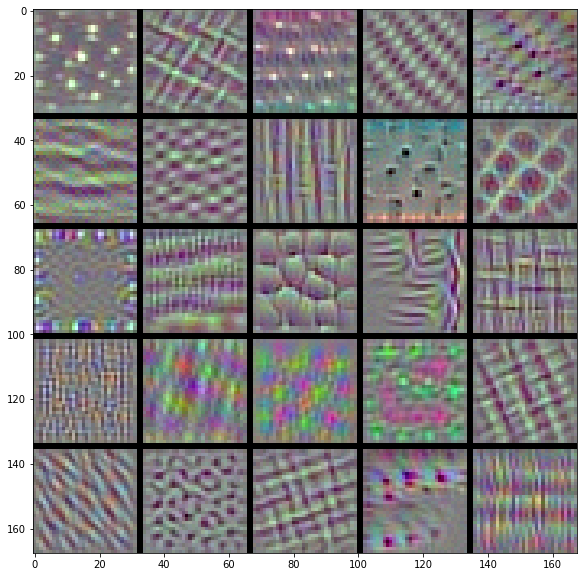

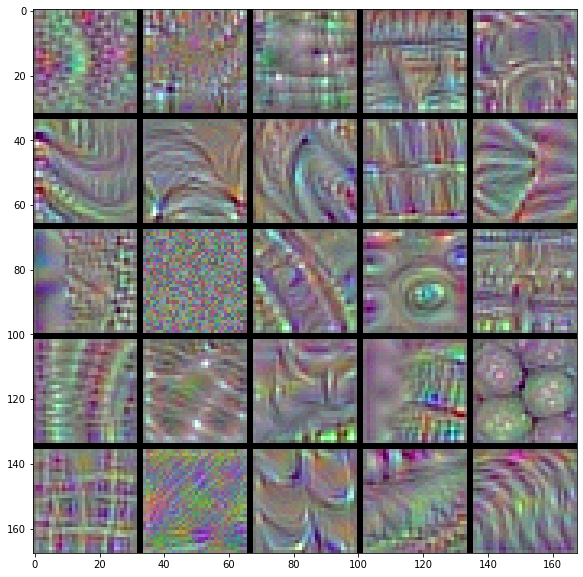

In [78]:
for layer_name in ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1']:
  size = 32
  margin = 2
  num_filters = 5
  results = np.zeros((num_filters*size + (num_filters-1)*margin, num_filters*size + (num_filters-1)*margin,3)).astype('uint8')

  for i in range(num_filters):
    for j in range(num_filters):
      filter_img = generate_pattern(layer_name, i + (j * num_filters), size)

      xstart = i*size + i*margin
      xend = xstart + size

      ystart = j*size + j*margin
      yend = ystart + size
      
      results[xstart:xend, ystart:yend,:] = filter_img
      # plt.imshow(filter_img)
      # plt.show()
  plt.figure(figsize=(10,10))
  plt.imshow(results)
  plt.show()

In [79]:
from keras.applications import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
K.clear_session()
model = VGG16()

In [80]:
img = image.load_img('creative_commons_elephant.jpg', target_size=(224,224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = model.predict(x)
print(decode_predictions(preds, top=3)[0])

[('n02504458', 'African_elephant', 0.90942055), ('n01871265', 'tusker', 0.086183496), ('n02504013', 'Indian_elephant', 0.0043545887)]


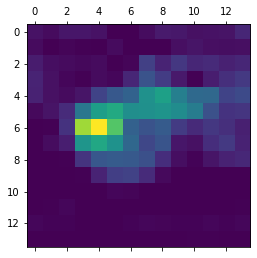

In [86]:
class_index = np.argmax(preds[0])
output_for_class = model.output[:,class_index]
last_conv_layer = model.get_layer('block5_conv3')
grads = K.gradients(output_for_class, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0,1,2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
  conv_layer_output_value[:,:,i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

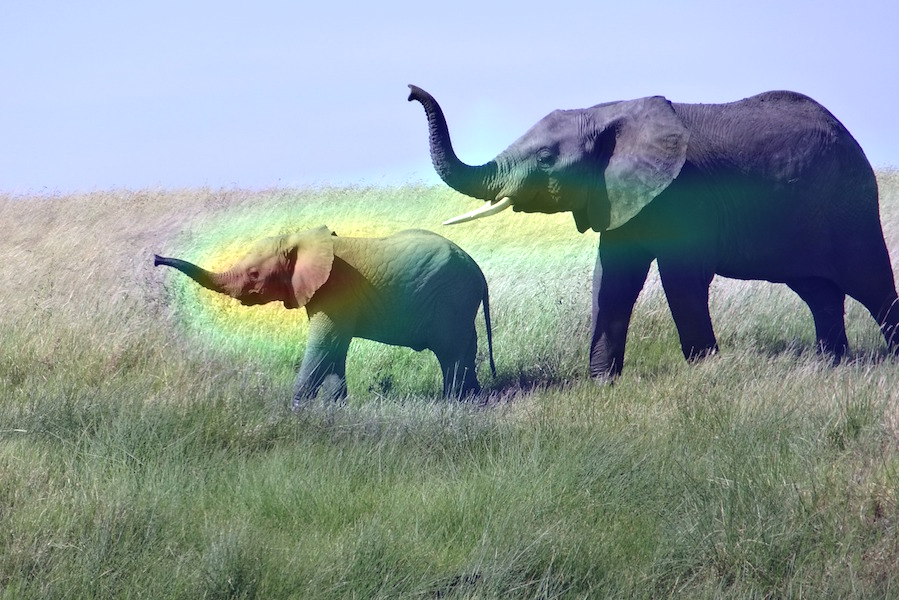

In [87]:
import cv2
img = cv2.imread('creative_commons_elephant.jpg')
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.2 + img
from google.colab.patches import cv2_imshow
cv2_imshow(superimposed_img)